# 1. Transfer learning: Shallow learning vs Finetuning, Pytorch

## 1.1 Fine-tuning from Imagenet
### (a)

In [15]:
# load image data from Visual Decathlon
!wget http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz

--2021-11-17 01:38:01--  http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz [following]
--2021-11-17 01:38:01--  https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406351554 (388M) [application/x-gzip]
Saving to: ‘decathlon-1.0-data.tar.gz’

decathlon-1.0-data. 100%[===================>] 387.53M   235MB/s    in 1.6s    

2021-11-17 01:38:03 (235 MB/s) - ‘decathlon-1.0-data.tar.gz’ saved [406351554/406351554]



In [17]:
!tar -xf decathlon-1.0-data.tar.gz

In [19]:
!tar -xf vgg-flowers.tar

In [23]:
!ls vgg-flowers

test  train  val


In [42]:
!wget http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz

--2021-11-17 01:53:29--  http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz [following]
--2021-11-17 01:53:29--  https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23503205 (22M) [application/x-gzip]
Saving to: ‘decathlon-1.0-devkit.tar.gz’

decathlon-1.0-devki 100%[===================>]  22.41M  --.-KB/s    in 0.1s    

2021-11-17 01:53:29 (150 MB/s) - ‘decathlon-1.0-devkit.tar.gz’ saved [23503205/23503205]



In [43]:
!tar -xf decathlon-1.0-devkit.tar.gz

In [55]:
!ls decathlon-1.0/annotations

aircraft_test_stripped.json	  imagenet12_test_stripped.json
aircraft_train.json		  imagenet12_train.json
aircraft_val.json		  imagenet12_val.json
cifar100_test_stripped.json	  omniglot_test_stripped.json
cifar100_train.json		  omniglot_train.json
cifar100_val.json		  omniglot_val.json
daimlerpedcls_test_stripped.json  svhn_test_stripped.json
daimlerpedcls_train.json	  svhn_train.json
daimlerpedcls_val.json		  svhn_val.json
dtd_test_stripped.json		  ucf101_test_stripped.json
dtd_train.json			  ucf101_train.json
dtd_val.json			  ucf101_val.json
gtsrb_test_stripped.json	  vgg-flowers_test_stripped.json
gtsrb_train.json		  vgg-flowers_train.json
gtsrb_val.json			  vgg-flowers_val.json


In [68]:
# this helps with data munging
!mv vgg-flowers decathlon-1.0/data

In [61]:
from json import load

with open('decathlon-1.0/annotations/vgg-flowers_train.json') as f:
    ann_train = load(f)
ann_train.keys()

dict_keys(['info', 'images', 'annotations', 'categories', 'licenses'])

In [152]:
# load raw images
import os
import numpy as np
from PIL import Image

X_train_raw = []
y_train = []


for img_data, ann_data in zip(ann_train['images'], ann_train['annotations']):
    assert ann_data['id'] == img_data['id']
    
    y_train.append(ann_data['category_id'])
    
    img = Image.open('decathlon-1.0/' + img_data['file_name'])
    X_train_raw.append(np.array(img))
    img.close()

category 100000001


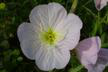

category 100000001


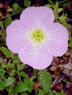

category 100000006


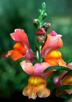

category 100000006


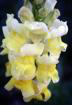

In [154]:
# show sample images
for i in [0, 1, 100, 101]:
    print('category %d' % y_train[i])
    img = Image.fromarray(X_train_raw[i])
    img.show()

In [99]:
print('number of unique classes:\t%d' % len(set(y_train)))

number of unique classes:	102


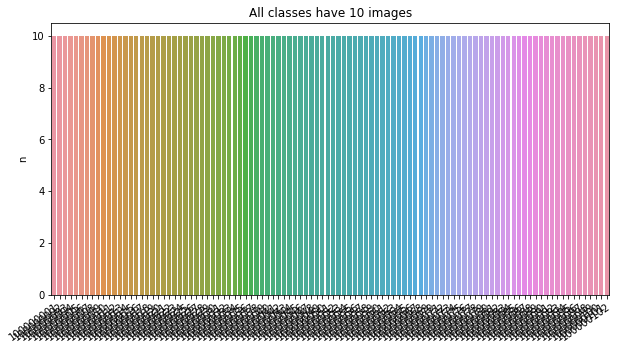

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

summary = pd.DataFrame.from_dict({y: y_train.count(y) for y in set(y_train)}, orient = 'index', columns = ['n'])
sns.barplot(data = summary, x = summary.index, y = 'n')
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.rcParams['figure.figsize'] = [10, 5]
plt.title('All classes have 10 images')
plt.show()



In [206]:
# preprocess images via PyTorch docs
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

X_train = []
for img in X_train_raw:
    img_pil = Image.fromarray(img)
    proc_img = preprocess(img_pil)
    X_train.append(proc_img)
    
X_train = torch.stack(X_train)

Effect of preprocessing images above


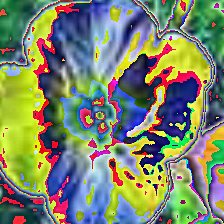

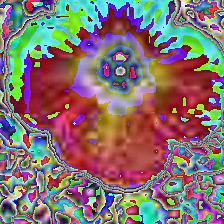

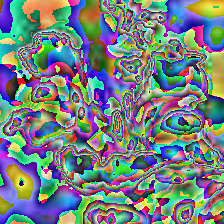

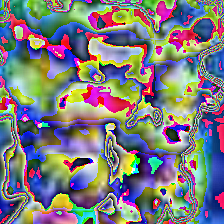

In [208]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

print("Effect of preprocessing images above")
for i in [0, 1, 100, 101]:
    img = to_img(X_train[i])
    img.show()

In [197]:
# load ResNet50
import torch
from torch import nn
from torchvision.models import resnet50

In [193]:
resnet = resnet50(pretrained = True)

In [200]:
# change the final fully connected layer output to the number of classes in the target dataset.
num_classes = 102
resnet.fc = nn.Linear(2048, num_classes)

In [203]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### (b) Fine tuning

In [210]:
# set the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers
learning_rate = 0.001
momentum = 0.9
epochs = 200

optimizer = torch.optim.SGD(resnet.parameters(), lr = learning_rate, momentum = momentum)
loss_fn = torch.nn.CrossEntropyLoss()

for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = resnet(X_train[0:10])
    print(y_pred)
    break

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)
    if t % 20 == 0:
        print(t, loss.item())

    # compute gradient
    optimizer.zero_grad()
    loss.backward()

    # update params
    optimizer.step()

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 8028160 bytes. Error code 12 (Cannot allocate memory)